## Breast cancer prediction
-----------------------------------

### About the dataset

This dataset is available through [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), or through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. The 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

For this project, we'll use machine learning to try to predict whether a cancer cell is benign or malignant based on a variety of cell attributes that were computed for each cell nucleus:

* ID number
* Diagnosis (M = malignant, B = benign)
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

### Kernel content
I. Import dependencies & load dataset

II. Exploratory data analysis (EDA)

III. Modeling

#### I. Import dependencies & load dataset:

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
%matplotlib inline
sns.set()

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

import xgboost

In [2]:
# Read data file:
df = pd.read_csv('data.csv')
df.drop(columns=['id', 'Unnamed: 32'], axis=1, inplace=True)
df.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [3]:
# Replacing the diagnosis of malignant or benign with 1s and 0s.
df['diagnosis'].replace({'M':1, 'B':0}, inplace = True)

In [4]:
# Inspect column datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [5]:
# Print out descriptive statistics:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


In [6]:
# report = ProfileReport(df) 
# report.to_file('breast_cancer_profile_report.html')

#### II. Exploratory data analysis (EDA)

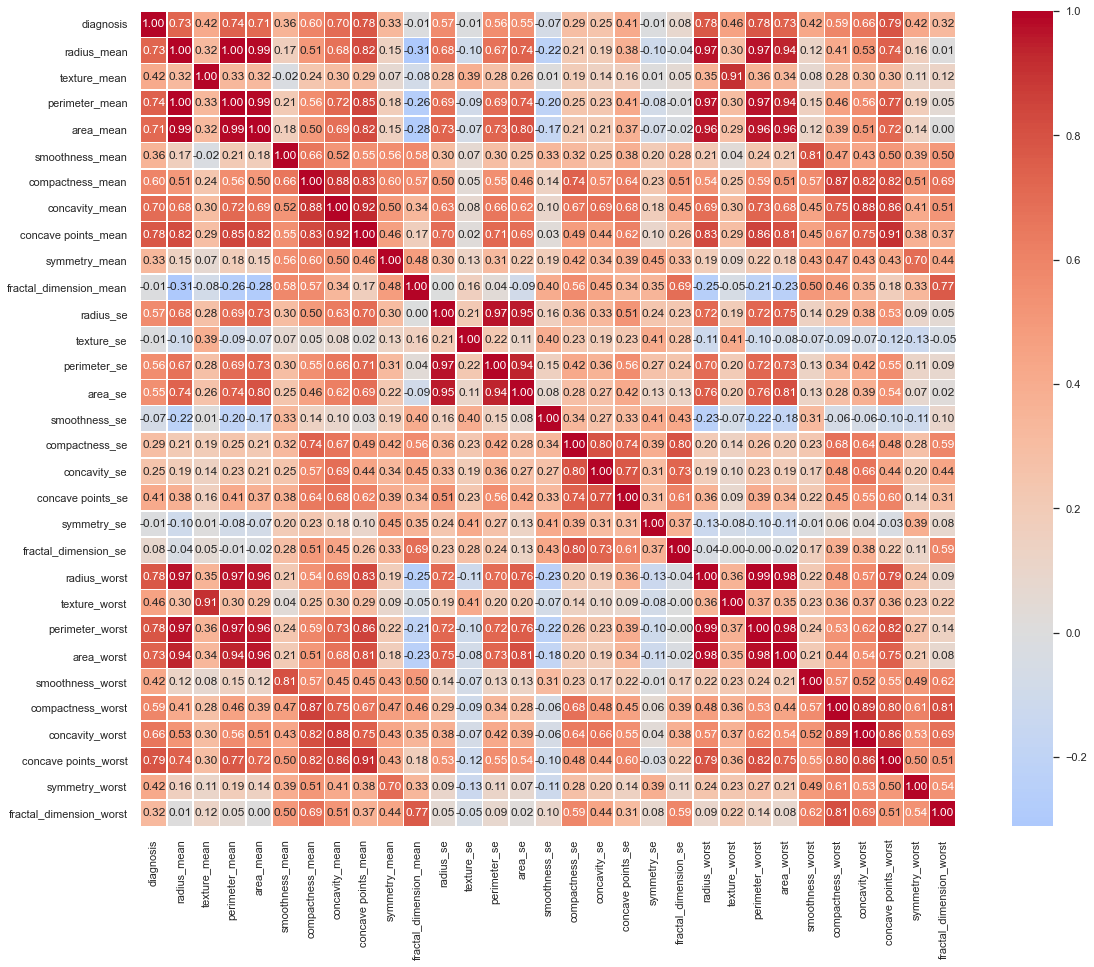

In [7]:
# Inspect feature correlation coefficient:
corr = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f', square=True,
            linewidths=.5, annot=True, cmap="coolwarm")

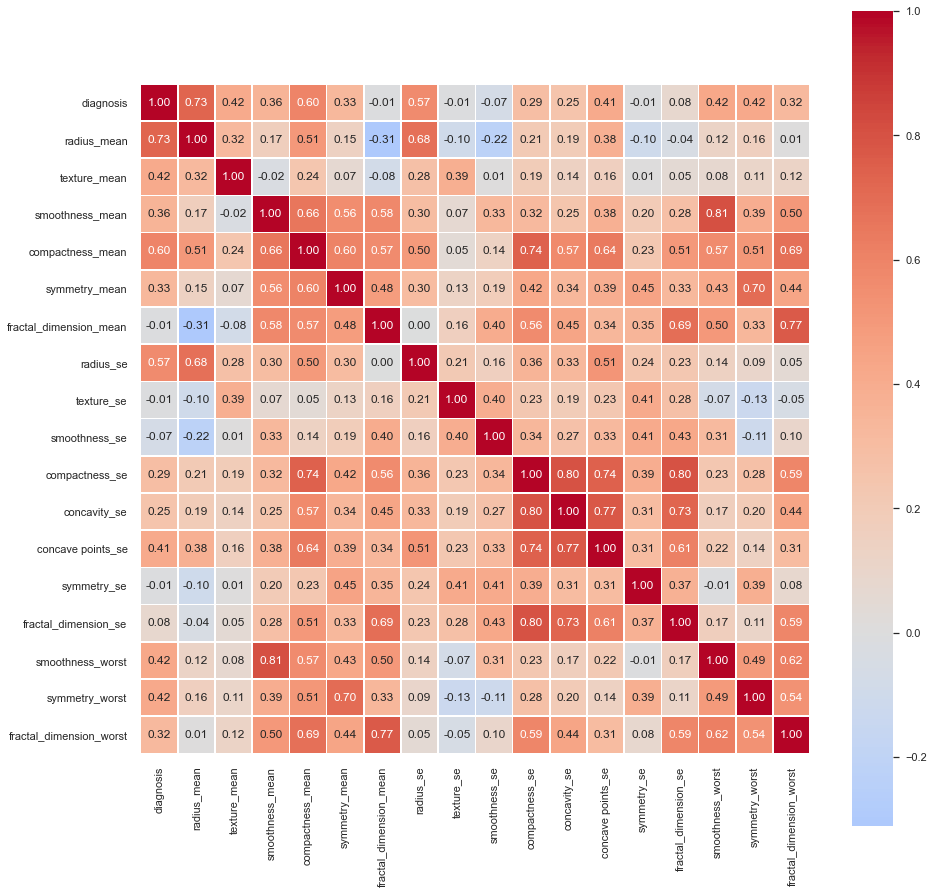

In [8]:
# Reduce features that are too highly correlated to avoid multicollinearity
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features
df.drop(to_drop, axis=1, inplace=True)

# Reprint correlation matrix
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr,
            vmax=1.0,
            center=0,
            fmt='.2f',
            square=True,
            linewidths=.5,
            annot=True,
            cmap="coolwarm")
plt.savefig("correlation_matrix.png")

In [9]:
# Scale the dataset:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Print out the dataset after scaling:
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df = scaled_df.drop(columns='diagnosis', axis=1)
scaled_df = pd.concat((scaled_df, df['diagnosis']), axis=1)

scaled_df.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.568466,3.283515,2.217515,2.255747,2.489734,-0.565265,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.307686,2.750622,1.937015,1
1,1.829821,-0.353632,-0.826962,-0.487072,0.001392,-0.868652,0.499255,-0.876244,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.243890,0.281190,1
2,1.579888,0.456187,0.942210,1.052926,0.939685,-0.398008,1.228676,-0.780083,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,0.527407,1.152255,0.201391,1
3,-0.768909,0.253732,3.283553,3.402909,2.867383,4.910919,0.326373,-0.110409,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,3.394275,6.046041,4.935010,1
4,1.750297,-1.151816,0.280372,0.539340,-0.009560,-0.562450,1.270543,-0.790244,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.868353,-0.397100,1


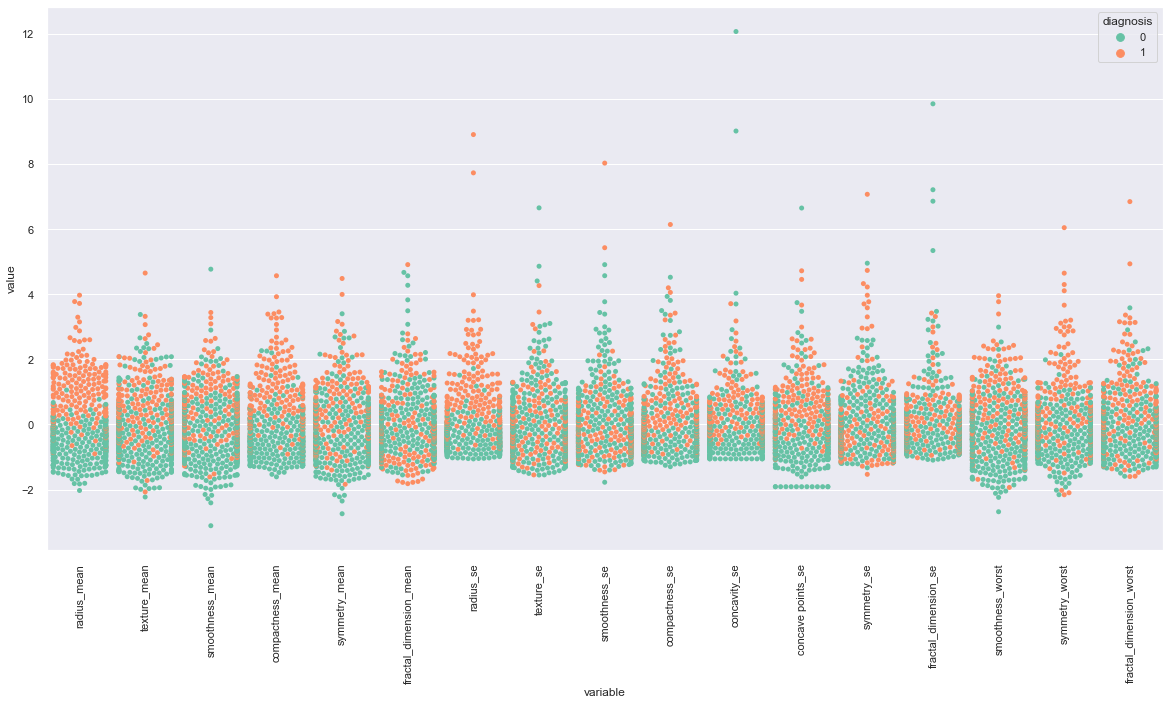

In [10]:
# Inspect each features against target variable:
data = pd.melt(scaled_df, id_vars='diagnosis')

sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(20, 10))

g = sns.swarmplot(x='variable', y='value', hue='diagnosis',
                  data=data, palette='Set2')

plt.xticks(rotation=90)
plt.savefig("features_swarmplot.png")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

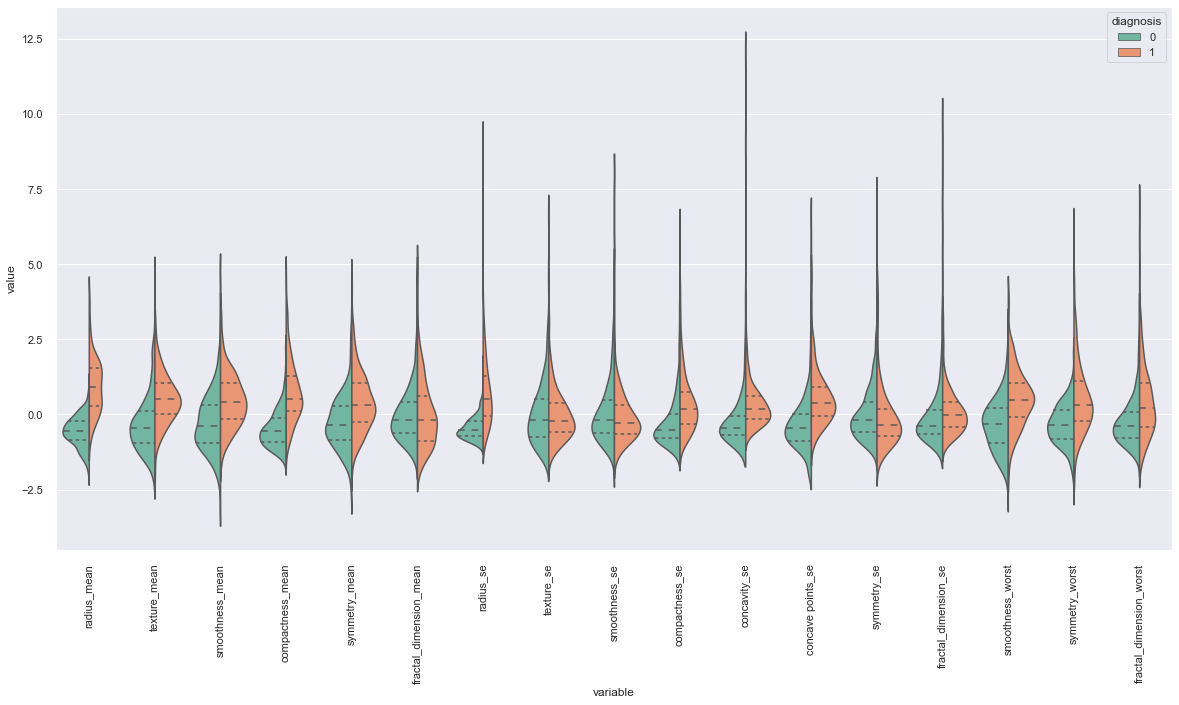

In [11]:
# Try violin plot to compare different quartiles:
plt.figure(figsize=(20, 10))
sns.violinplot(x='variable', y='value', hue='diagnosis',
               data=data, palette='Set2', split=True, inner="quartile")
plt.xticks(rotation=90)

In [12]:
# Split the data into explanatory variables and target variable
X = scaled_df.iloc[:,:-1]
y = scaled_df['diagnosis']

In [13]:
# Applying PCA to reduce the dimensionality of the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=8, svd_solver='randomized',whiten=True)
pca_components = pca.fit(X)
X_pca = pca.transform(X)

In [14]:
# Amount of variance explained by PCA with 8 components:
print(pca.explained_variance_ratio_.sum())

0.9190823271634646


In [15]:
X_pca.shape

(569, 8)

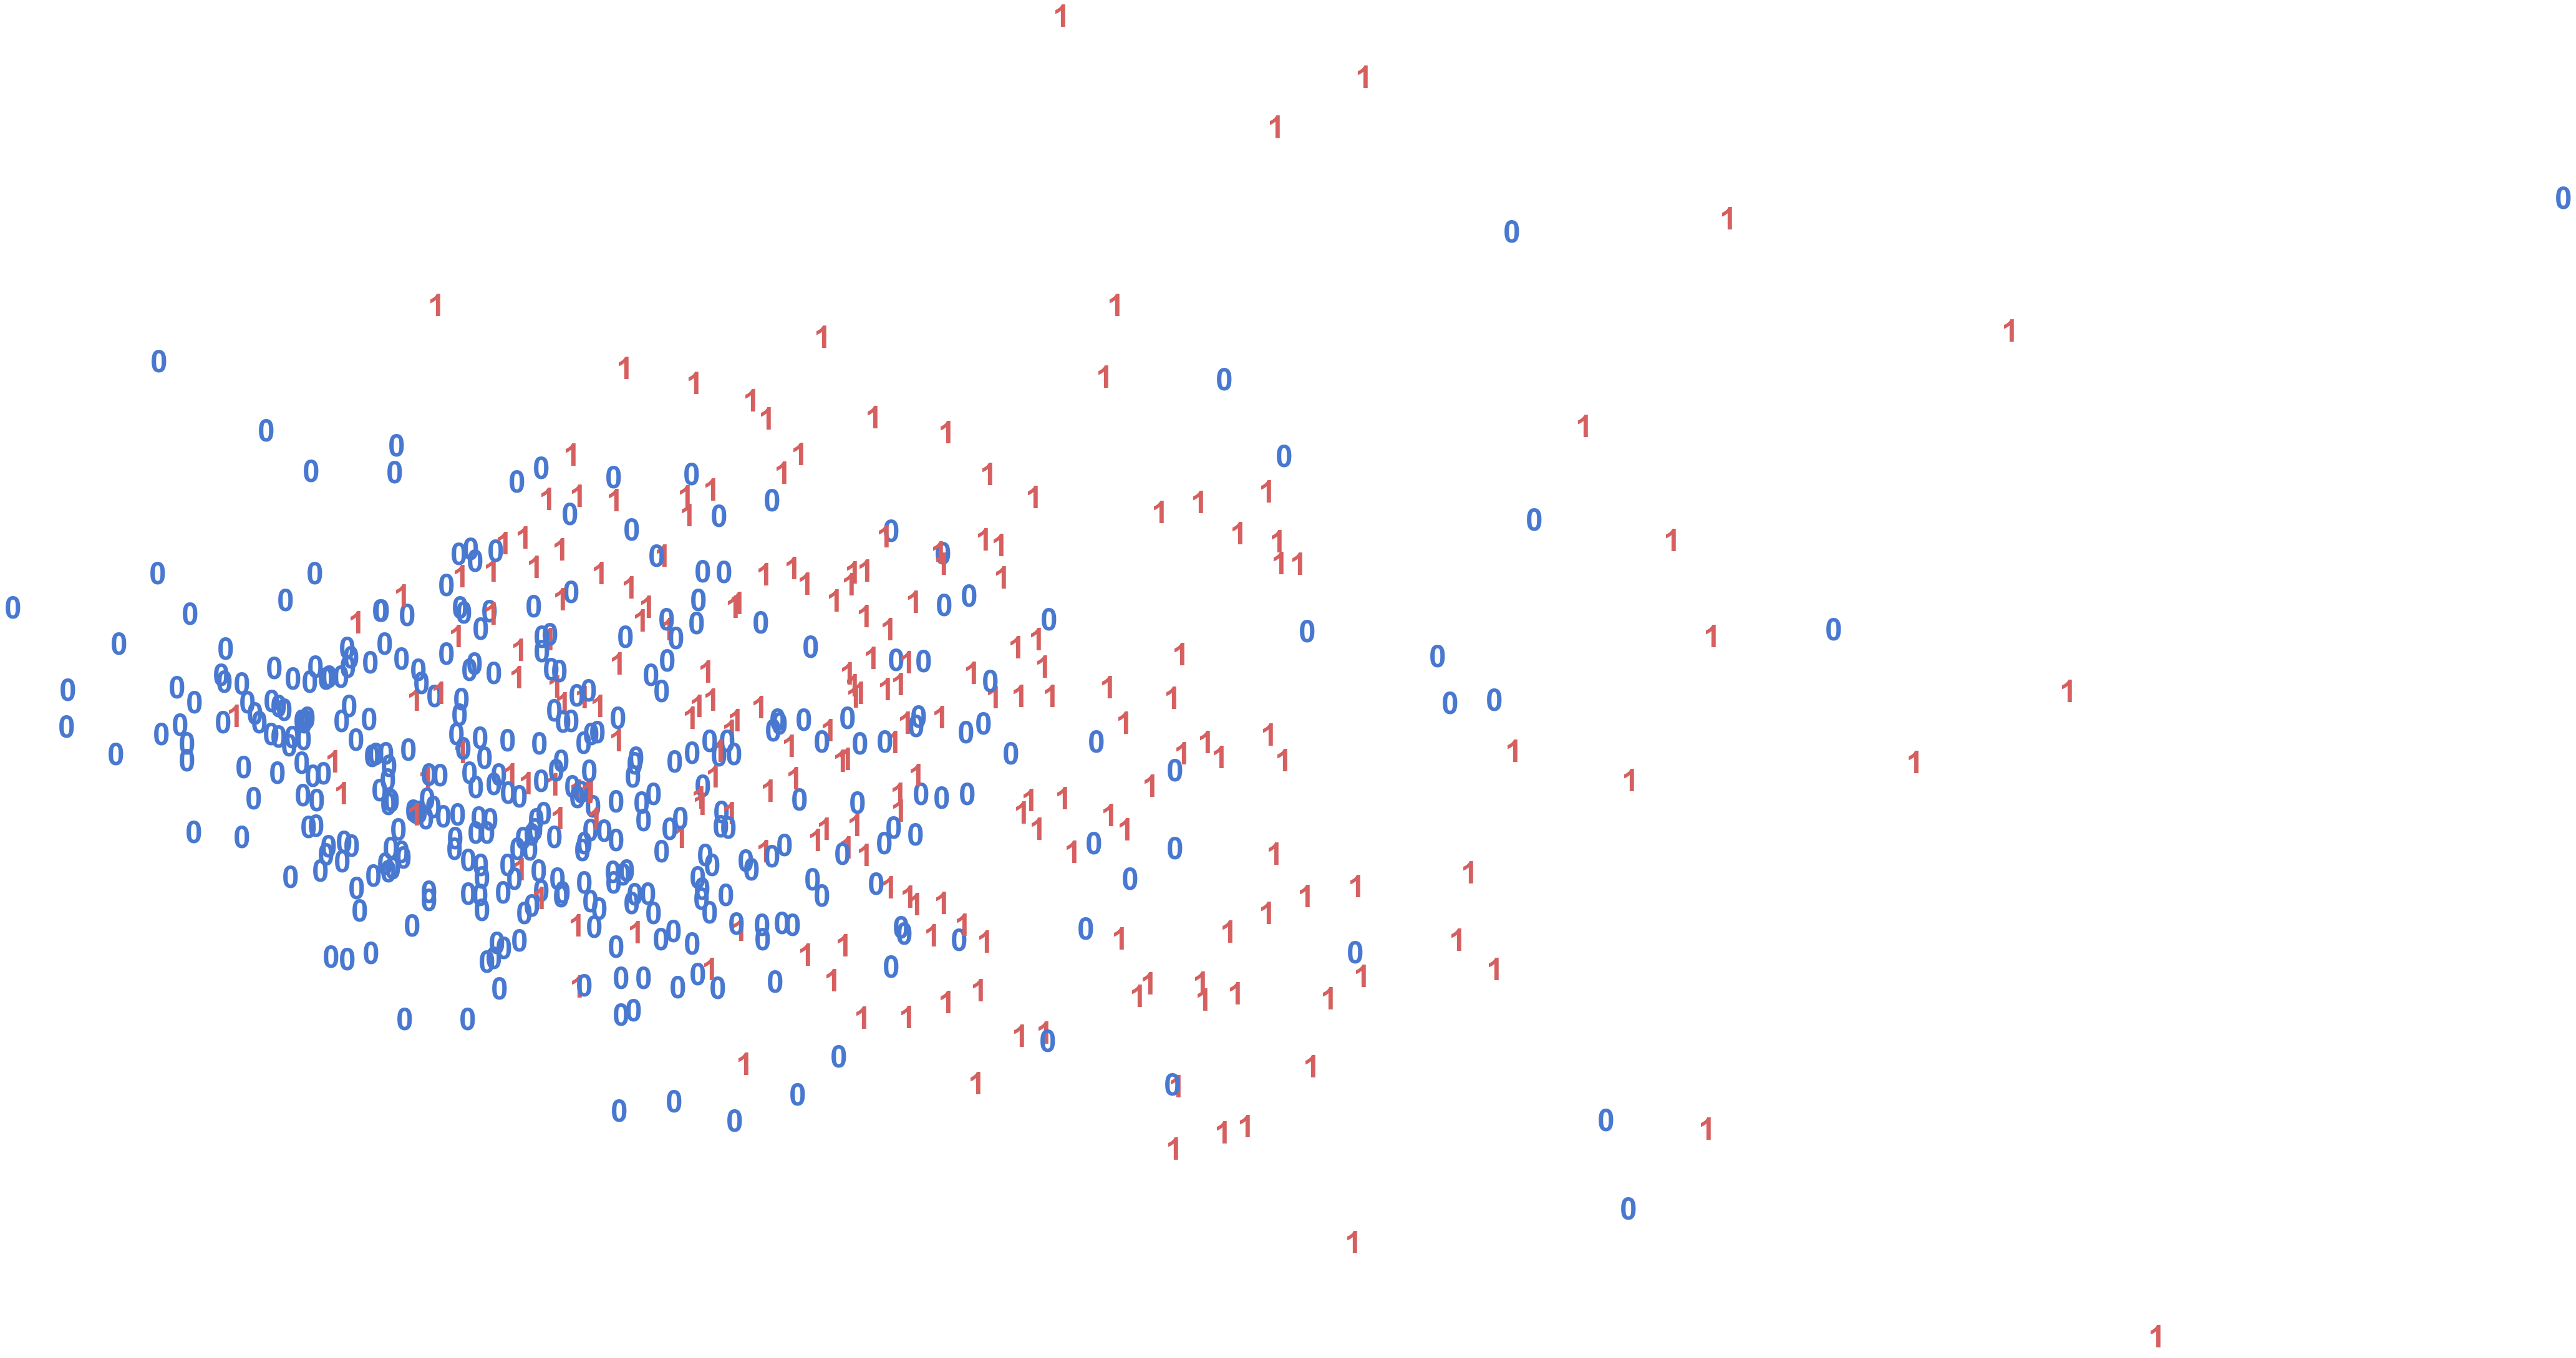

In [16]:
# Visualize data after applying PCA
plt.figure(figsize=(10, 5))
sns.set_style('dark')
colours = ["b", "r"]
for i in range(X_pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
             )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("pca_viz.png")
plt.show()

#### III. Build predictive models

In [17]:
# Split the data into train & test set:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.25, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(426, 8) (426,)
(143, 8) (143,)


In [18]:
# Use SMOTE to handle class imbalance:
sm = SMOTE(random_state=123)
X_train_os, y_train_os = sm.fit_sample(X_train, y_train.ravel())

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print(' ')
print("After OverSampling, counts of label '1': {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_os == 0)))

# Reassign newly sampled dataset:
X_train = X_train_os
y_train = y_train_os

print(' ')
print('The shape of data after handling class imbalance is ')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Before OverSampling, counts of label '1': 158
Before OverSampling, counts of label '0': 268
 
After OverSampling, counts of label '1': 268
After OverSampling, counts of label '0': 268
 
The shape of data after handling class imbalance is 
(536, 8) (536,)
(143, 8) (143,)


In [19]:
# Helper function to execute the model and calculate accuracy score
def model_execute(mod, model_name, X_train, y_train, X_test, y_test):
    %timeit mod.fit(X_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    y_pred = mod.predict(X_test)
    print('')
    print('Accuracy on train set is {}'.format(acc.mean()))
    print('Accuracy on test set is {}'.format(accuracy_score(y_test, y_pred)))
    print('F1 score is {}'.format(metrics.f1_score(y_test, y_pred)))
    print('Precision score is {}'.format(metrics.precision_score(y_test, y_pred)))
    print('Recall score is {}'.format(metrics.recall_score(y_test, y_pred)))
    
    cm = confusion_matrix(y_pred,y_test)
    print('Confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, figsize=(8,5), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
    plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
    plt.show()

3.68 ms ± 48.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Logistic Regression

Accuracy on train set is 0.9607822776047076
Accuracy on test set is 0.9790209790209791
F1 score is 0.9719626168224299
Precision score is 0.9811320754716981
Recall score is 0.9629629629629629
Confusion matrix


<Figure size 432x288 with 0 Axes>

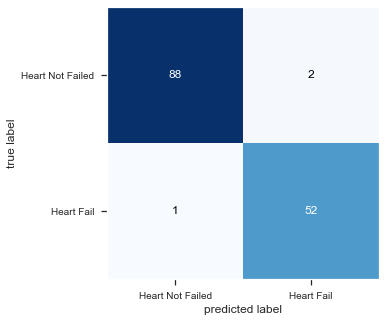

In [20]:
# Logistic regression:
lr = LogisticRegression(random_state = 123)
model_execute(lr, 'Logistic Regression', X_train, y_train, X_test, y_test)

2.29 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Support Vector Classifier

Accuracy on train set is 0.9551748009691936
Accuracy on test set is 0.965034965034965
F1 score is 0.9541284403669724
Precision score is 0.9454545454545454
Recall score is 0.9629629629629629
Confusion matrix


<Figure size 432x288 with 0 Axes>

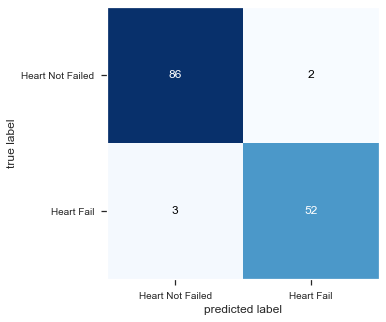

In [21]:
# Support vector machine
svc = SVC(kernel = 'linear', random_state = 123)
model_execute(svc, 'Support Vector Classifier', X_train, y_train, X_test, y_test)

227 ms ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Random Forest Classifier

Accuracy on train set is 0.8973693319487712
Accuracy on test set is 0.9370629370629371
F1 score is 0.9090909090909091
Precision score is 1.0
Recall score is 0.8333333333333334
Confusion matrix


<Figure size 432x288 with 0 Axes>

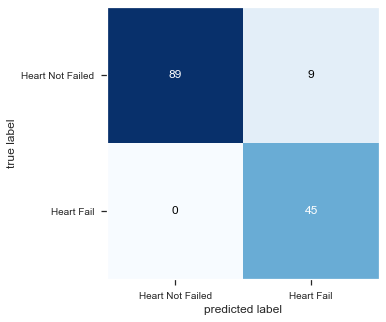

In [22]:
# Random forest classifier:
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=2, random_state=123)
model_execute(rfc, "Random Forest Classifier", X_train, y_train, X_test, y_test)

370 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
K Nearest Neighbors

Accuracy on train set is 0.9328141225337486
Accuracy on test set is 0.9440559440559441
F1 score is 0.9272727272727271
Precision score is 0.9107142857142857
Recall score is 0.9444444444444444
Confusion matrix


<Figure size 432x288 with 0 Axes>

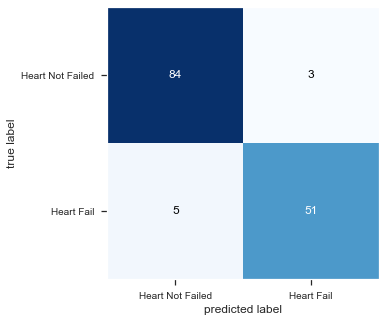

In [23]:
# K-nearst-neighbor(KNN)
knn = KNeighborsClassifier(n_neighbors = 8, n_jobs=-1)
model_execute(knn, "K Nearest Neighbors", X_train, y_train, X_test, y_test)